# MT pseudo-alignment to determine founder donors

Imports.

In [1]:
import numpy as np # data management
import pandas as pd # data management

import genotype_helpers # genotype processing
import io_helpers # file I/O


This I/O helper file uses:
Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)],
Matplotlib version 3.7.1,
pandas version 1.5.3


This genotype helper file adds:
NumPy version 1.24.3,
pyMSAviz version 0.4.0,
scikit-allel version 1.3.6



Load unfiltered genotypes.

In [2]:
mt_modern = genotype_helpers.get_genotypes(
    genotype_helpers.SHALLOW_MODERN_FILE, 'MT', format='nucleotide',
    
    use_maf_filter=False, use_miss_filter=False
)

Read 117 variants across 15120 samples
Filtering out 0 variants for INFO score < 0.85
Genotypes for 15120 rats across 117 variants


In [3]:
mt_founders = genotype_helpers.get_genotypes(
    genotype_helpers.FOUNDERS_FILE, 'MT', format='nucleotide', 
    
    variant_subset=mt_modern.columns,
    use_maf_filter=False, use_miss_filter=False
    )

Read 122 variants across 8 samples
5 variants removed for not being in the given subset
Genotypes for 8 rats across 117 variants


Determine MT haplotypes.

In [4]:
unique_mt_modern = mt_modern.dropna(axis=0, how='any').drop_duplicates()

print(f'There are {unique_mt_modern.shape[0]} unique modern haplotypes')
print(f'There are {len(mt_founders.drop_duplicates().index)}' 
      ' unique founder haplotypes')

group1 = np.logical_or(mt_modern == unique_mt_modern.iloc[0], 
                       # missing '' calls count as matching
                       pd.isna(mt_modern)).all(axis=1)
group2 = np.logical_or(mt_modern == unique_mt_modern.iloc[1], 
                       pd.isna(mt_modern)).all(axis=1)

print('All rats perfectly match at least one haplotype group: '
      f'{np.logical_or(group1, group2).all()}')

There are 2 unique modern haplotypes
There are 4 unique founder haplotypes
All rats perfectly match at least one haplotype group: True


Identify founder donors.

In [5]:
mt_founders.eq(unique_mt_modern.iloc[0]).all(axis=1)

ACI     False
BN       True
BUF     False
F344    False
M520    False
MR      False
WKY     False
WN      False
dtype: bool

In [6]:
mt_founders.eq(unique_mt_modern.iloc[1]).all(axis=1)

ACI     False
BN      False
BUF      True
F344     True
M520     True
MR       True
WKY     False
WN       True
dtype: bool

In [7]:
mt_snps = genotype_helpers.filter_maf(unique_mt_modern)

# format with SNPs as rows and haplotypes as columns
mt_snps = mt_snps.reset_index(drop=True).T
mt_snps.columns = ['REF', 'ALT']
mt_snps.reset_index(names='POS', inplace=True)

genotype_helpers.write_snp_vcf(mt_snps, 'MT')
mt_snps

Filtering out 40 variants for MAF=0


,POS,REF,ALT,#CHROM,ID,QUAL,FILTER,INFO
0,648,A,C,NC_001665.2,MT:648,50,PASS,.
1,935,G,A,NC_001665.2,MT:935,50,PASS,.
2,942,T,C,NC_001665.2,MT:942,50,PASS,.
3,1099,T,C,NC_001665.2,MT:1099,50,PASS,.
4,1223,G,A,NC_001665.2,MT:1223,50,PASS,.
...,...,...,...,...,...,...,...,...
72,15507,T,C,NC_001665.2,MT:15507,50,PASS,.
73,15549,T,C,NC_001665.2,MT:15549,50,PASS,.
74,15568,G,A,NC_001665.2,MT:15568,50,PASS,.
75,15579,A,G,NC_001665.2,MT:15579,50,PASS,.


Create MT pseudo-alignment. This is *Figure 2D*.

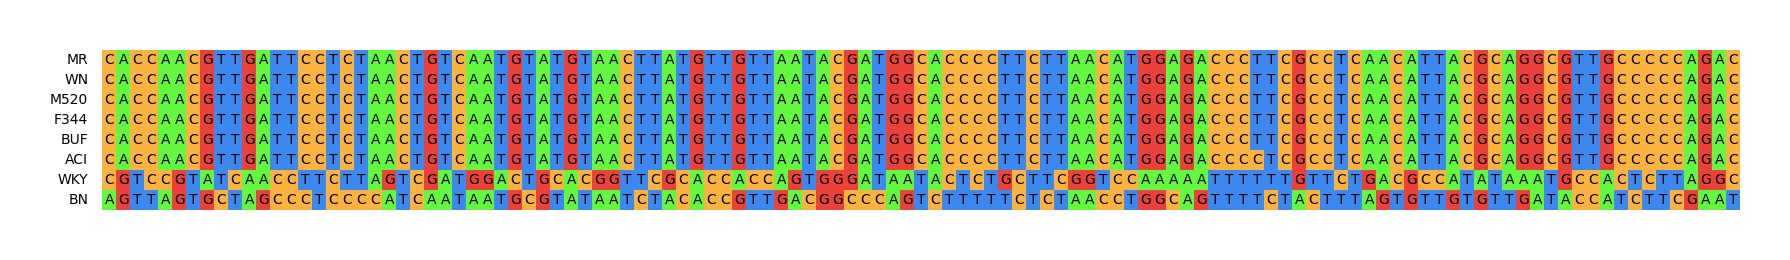

In [8]:
mt_founders = mt_founders.loc[['MR', 'WN', 'M520', 'F344',
                               'BUF', 'ACI', 'WKY', 'BN']]

fig = genotype_helpers.plot_align(mt_founders, basename='all_MT')

io_helpers.save_plot('all_MT_MSA')